# SARSA On-Policy Control

We will be using **TD control method of SARSA** on Cliff World environment as given below:  

![GridWorld](./images/cliffworld.png "Cliff World")


### SARSA On-Policy control

SARSA control is carried out by sampling step by step and updating Q values at each step. This leads to continuous improvement of ε-greedy policy. The Update equation is given below:

$$ Q(S,A) \leftarrow Q(S,A) + \alpha \cdot [ R + \gamma \cdot Q(S’,A’) – Q(S,A)] $$

In terms of the equation 4.9 given in book this translates to:
$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha  [ R_{t+1} + \gamma \cdot  Q(S_{t+1},A_{t+1}) – Q(S_t,A_t)] $$



#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter4


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /kaggle/working/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter4

In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

In [18]:
# Initial imports and environment setup
import gymnasium as gym
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

### SARSA Agent

In [19]:
# SARSA Learning agent class
from collections import defaultdict

class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        if not done:
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [20]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, terminated, _, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, terminated)
            G += reward
            if terminated:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [21]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.xlabel("Episode number")
    plt.ylabel("Return per episode")
    plt.show()

In [28]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'
    print("Policy learnt by Agent\n")    

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

In [23]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])    
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()    
    for _ in range(video_length + 1):
        action = agent.max_action(obs[0])
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]   
    # Save the video
    vec_env.close()
    return file_path

## Cliff Walking SARSA

#### Create SARSA Agent for Cliff world environment and train agent

In [24]:
# create cliff world environment
env = gym.make("CliffWalking-v0")

In [25]:
# create a SARSA agent
agent = SARSAAgent(
            alpha=0.20,
            epsilon=0.5,
            gamma=0.99,
            get_possible_actions=lambda s : range(env.nA)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 1000)

#### Plot Rewards

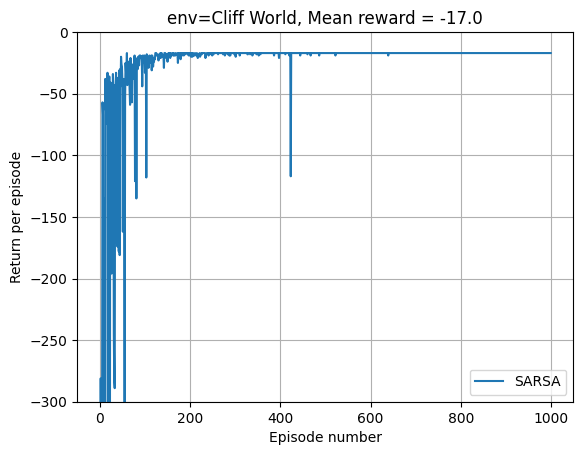

In [27]:
# plot rewards
plot_rewards("Cliff World",rewards, 'SARSA')

#### Print Policy

In [29]:
# print policy
print_policy(env, agent)

Policy learnt by Agent

 >  >  >  >  >  >  >  >  >  >  v  v 
 ^  ^  >  >  >  >  >  >  >  >  >  v 
 ^  ^  <  ^  ^  ^  >  >  ^  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


#### Watch trained agent

In [11]:
env_id = "CliffWalking-v0"
video_folder = "logs/videos/"
video_length = 50
               
video_file = record_video(env_id, video_folder, video_length, agent)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-CliffWalking-v0-step-0-to-step-50.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-CliffWalking-v0-step-0-to-step-50.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-CliffWalking-v0-step-0-to-step-50.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-CliffWalking-v0-step-0-to-step-50.mp4


In [12]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## SARSA On-Policy for "Taxi" environment 

Let us now repeat all the above steps for another environment


#### Create SARSA Agent for Taxi enviroment and train agent

In [13]:
# create taxi environment
env = gym.make("Taxi-v3")

# create a SARSA agent
agent = SARSAAgent(
            alpha=0.25, 
            epsilon=0.2, 
            gamma=0.99, 
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)


#### Plot Rewards

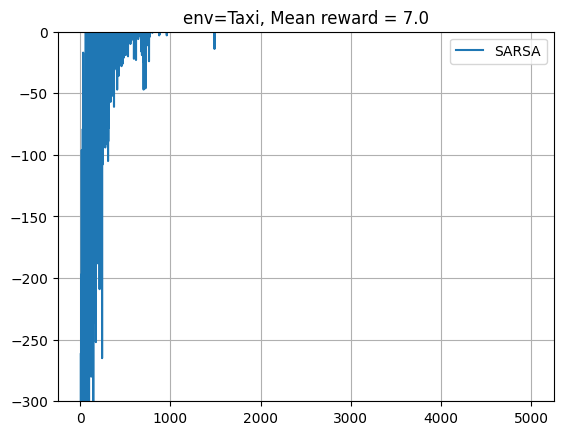

In [14]:
#plot reward graph
plot_rewards("Taxi", rewards, 'SARSA')

#### Watch Trained Agent

In [15]:
env_id = "Taxi-v3"
video_folder = "logs/videos/"
video_length = 200
               
video_file = record_video(env_id, video_folder, video_length, agent)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-Taxi-v3-step-0-to-step-200.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-Taxi-v3-step-0-to-step-200.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-Taxi-v3-step-0-to-step-200.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter4/logs/videos/SARSAAgent-Taxi-v3-step-0-to-step-200.mp4


In [16]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Conclusion

We see that SARSA agent learns the optimal policy by end of 500 episodes of training. The policy learnt is to avoid the cliff by first going all the way up and then taking a right turn to walk towards the goal. This is surprising as we would have expected the agent to learn the policy to skirt over the cliff and reach goal which would have been the shortest path, a path shorter by 4 steps as compared to the one learnt by agent. 

However, as our policy continues to explore using ε-greedy, there is always a small chance that agent when next to a cliff cell, takes a random action and falls into the cliff. It demonstrates the issue of continued exploration even when enough has been learnt about the environment i.e. when same ε-greedy policy is used for sampling as well for improvement. 